In [1]:
import torch
import os
import subprocess

repo_root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"]).decode().strip()
os.chdir(repo_root)

print("cwd =", os.getcwd())

from solvers.torch_eit_fem_solver import EIT
from solvers.torch_eit_fem_solver.fem import Mesh, V_h, dtn_map
from solvers.torch_eit_fem_solver.utils import dtn_from_sigma
from torchdiffeq import odeint
import matplotlib.pyplot as plt
import cmocean as cmo
from scipy import io as sio
from tqdm import tqdm
from models.unet import Unet
from collections import OrderedDict
import numpy as np

device = 'cuda:1' 

train_dataset = torch.load('data/eit-circles-dtn-default-128.pt', map_location="cpu")

data_root = 'mesh-data'
mesh_file = 'mesh_128_h05.mat'
mat_fname = os.path.join(data_root, mesh_file)
mat_contents = sio.loadmat(mat_fname)

p = torch.tensor(mat_contents['p'], dtype=torch.float64).to(device)
t = torch.tensor(mat_contents['t']-1, dtype=torch.long).to(device)
vol_idx = torch.tensor(mat_contents['vol_idx'].reshape((-1,))-1, dtype=torch.long).to(device)
bdy_idx = torch.tensor(mat_contents['bdy_idx'].reshape((-1,))-1, dtype=torch.long).to(device)

mesh = Mesh(p, t, bdy_idx, vol_idx)
v_h = V_h(mesh)

dtn_background = dtn_from_sigma(sigma_vec=torch.ones(128, 128), v_h=v_h, mesh=mesh, img_size=128, device=device).cpu()

train_X = train_dataset['train']['dtn_map'].float()
train_X /= dtn_background
train_Y = train_dataset['train']['media'].float()

train_X_min = train_X.min()
train_X_max = train_X.max()
train_Y_min = train_Y.min()
train_Y_max = train_Y.max()

cwd = /home/johnma/flow-inverse


In [2]:
from models.conditional_models import ConditionalConcatUnet

model = ConditionalConcatUnet(unet_ch=32).to(device)

checkpoint = torch.load(
    "saved_runs/circles-eit-concat-unet-flow-default-bg-transform_run1/checkpoints/ckp_31500.tar",
    map_location=device,
)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

ConditionalConcatUnet(
  (unet): Unet(
    (input_proj): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_proj): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (down): ModuleList(
      (0): ModuleList(
        (0-1): 2 x ResBlock(
          (skip_connection): Identity()
          (block1): Sequential(
            (0): GroupNorm(32, 32, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Identity()
            (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (block2): Sequential(
            (0): GroupNorm(32, 32, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Dropout(p=0.1, inplace=False)
            (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (cond_block): ConditioningBlock(
            (proj): Sequential(
            

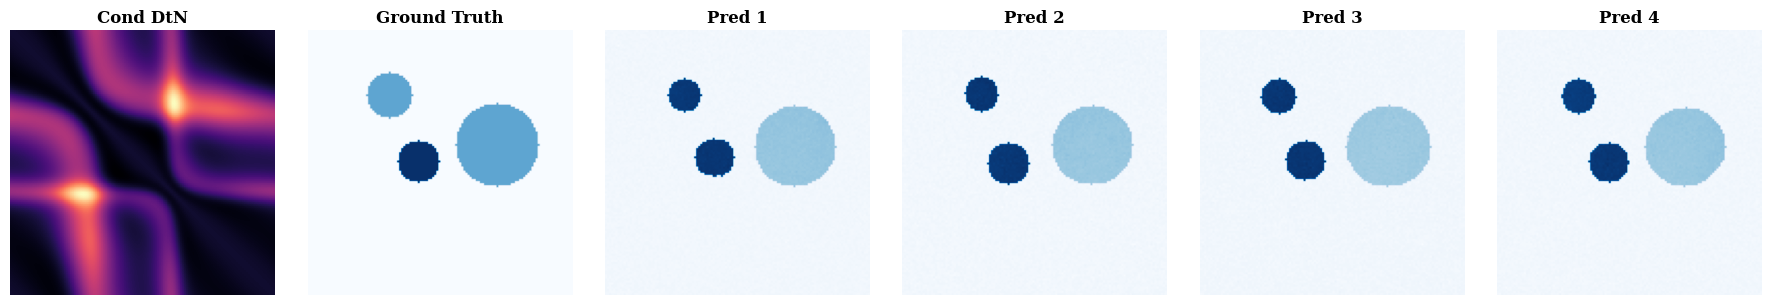

In [18]:
import matplotlib.pyplot as plt
train_dataset = torch.load('data/eit-circles-dtn-default-128.pt', map_location="cpu")
idx = 9
x_cond = train_dataset["val"]["dtn_map"][idx].repeat(4, 1, 1, 1)
x_cond /= dtn_background
x_cond = 2.0 * (x_cond - train_X_min) / (train_X_max - train_X_min + 1e-12) - 1.0
x_cond = x_cond.to(device)

z0 = torch.randn(4, 1, 128, 128, device=device)

def v_from_x_pred(z, t):
    guidance_scale = 5.0
    t_batch = t.expand(z.shape[0])
    with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
        v_uncond = model(z, torch.zeros_like(x_cond), t_batch)
        v_cond = model(z, x_cond, t_batch)
    return v_uncond + guidance_scale * (v_cond - v_uncond)

timesteps = torch.linspace(0.0, 1.0, steps=5).to(device)
with torch.no_grad():
    pred = odeint(
        func = lambda t, x: v_from_x_pred(x, t),
        t = timesteps,
        y0 = z0,
        method = 'dopri5',
        atol = 1e-5,
        rtol = 1e-5, 
    )[-1]

# Unnormalize predictions
pred = 0.5 * (pred + 1.0) * (train_Y_max - train_Y_min) + train_Y_min

plt.rcParams["font.family"] = "DejaVu Serif"
title_font = {"family": "DejaVu Serif", "weight": "bold", "size": 12}

fig, axes = plt.subplots(1, 6, figsize=(18, 3))

x_cond_vis = 0.5 * (x_cond[0] + 1.0) * (train_X_max - train_X_min) + train_X_min
y_gt = 0.5 * (train_dataset["val"]["media"][idx:idx+1].to(device) + 1.0) * (train_Y_max - train_Y_min) + train_Y_min

axes[0].imshow(x_cond_vis.squeeze(0).detach().cpu().numpy(), cmap="magma")
axes[0].set_title("Cond DtN", fontdict=title_font)
axes[0].axis("off")

axes[1].imshow(y_gt[0].squeeze().detach().cpu().numpy(), cmap="Blues")
axes[1].set_title("Ground Truth", fontdict=title_font)
axes[1].axis("off")

for i in range(4):
    img = pred[i].squeeze().cpu().numpy()
    axes[i + 2].imshow(img, cmap="Blues")
    axes[i + 2].set_title(f"Pred {i + 1}", fontdict=title_font)
    axes[i + 2].axis("off")

plt.tight_layout()
plt.show()


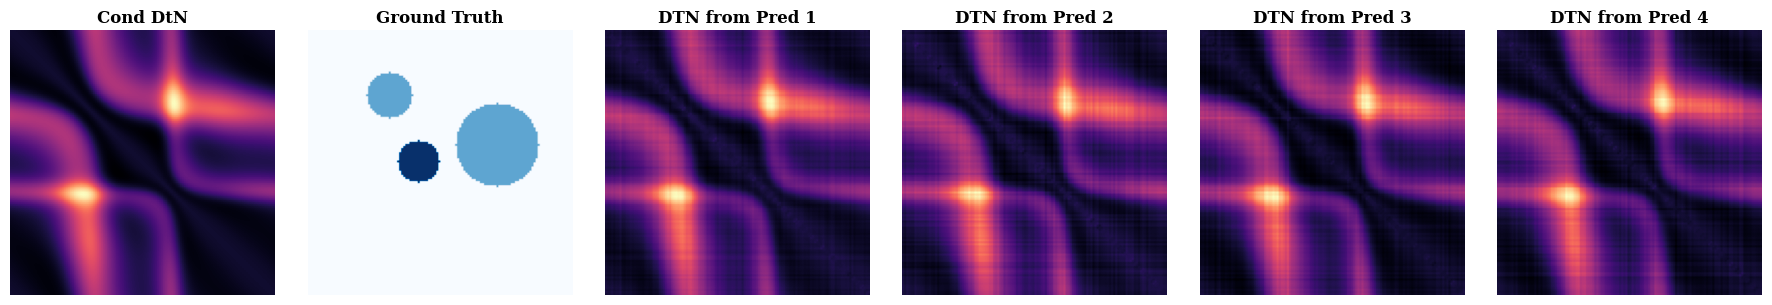

In [19]:
# compare against dtns / dtn_background
pred_dtns = []
with torch.no_grad():
    for i in range(pred.shape[0]):
        sigma_pred = pred[i:i+1]  # Keep batch dimension
        dtn_pred = dtn_from_sigma(sigma_vec=sigma_pred.squeeze(), v_h=v_h, mesh=mesh, img_size=128, device=device)
        pred_dtns.append(dtn_pred)
pred_dtns = torch.stack(pred_dtns)
# Normalize the predicted DTNs using the same normalization as training
pred_dtns_normalized = pred_dtns / dtn_background
pred_dtns_normalized = 2.0 * (pred_dtns_normalized - train_X_min) / (train_X_max - train_X_min + 1e-12) - 1.0
# Plot in the same style as Cell 2
plt.rcParams["font.family"] = "DejaVu Serif"
title_font = {"family": "DejaVu Serif", "weight": "bold", "size": 12}
fig, axes = plt.subplots(1, 6, figsize=(18, 3))
# Original conditional DtN
axes[0].imshow(x_cond_vis.squeeze(0).detach().cpu().numpy(), cmap="magma")
axes[0].set_title("Cond DtN", fontdict=title_font)
axes[0].axis("off")
# Ground truth media
axes[1].imshow(y_gt[0].squeeze().detach().cpu().numpy(), cmap="Blues")
axes[1].set_title("Ground Truth", fontdict=title_font)
axes[1].axis("off")
# DTNs computed from predictions
for i in range(4):
    img = pred_dtns_normalized[i].squeeze().cpu().numpy()
    axes[i + 2].imshow(img, cmap="magma")
    axes[i + 2].set_title(f"DTN from Pred {i + 1}", fontdict=title_font)
    axes[i + 2].axis("off")
plt.tight_layout()
plt.show()
